## Notebook to create a smoothed implied volatility surface using delta

Trying to follow iVolatility.com's methodology - found here: https://www.ivolatility.com/doc/deltasurfacemethodology.pdf

Using Yahoo Option data.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm.notebook import tqdm
from scipy.stats import norm
import pandas as pd
import numpy as np
import finpie
import datetime as dt
import functions as fn

plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Roboto'
plt.rcParams['font.monospace'] = 'Roboto Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 48
plt.rcParams[ "figure.figsize"] = (20, 10)
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
calls, puts = finpie.yahoo_option_chain('SPY')
underlying = finpie.yahoo_prices('SPY')

In [3]:
calls = calls[ ~calls.in_the_money]
calls['time_to_expiration'] = (calls[calls.open_interest > 10].expiration - dt.datetime.today()) / dt.timedelta(365,0,0,0)
calls = calls[calls.implied_volatility >= 0.05 ]
calls.dropna(inplace = True)
calls.reset_index(inplace = True, drop = True)
calls = calls[ calls['time_to_expiration'] > 0 ]
calls['log_moneyness'] = np.log(calls.strike / underlying.close[-1])
calls['log_moneyness_squared'] = calls['log_moneyness']**2
calls['option'] = 'calls'
calls = calls[ (calls.bid != 0) & (calls.ask != 0)  ] 
calls['price'] = (calls.ask + calls.bid) / 2

In [4]:
puts = puts[ ~puts.in_the_money]
puts['time_to_expiration'] = (puts[puts.open_interest > 10].expiration - dt.datetime.today()) / dt.timedelta(365,0,0,0)
puts = puts[puts.implied_volatility >= 0.05 ]
puts.dropna(inplace = True)
puts.reset_index(inplace = True, drop = True)
puts = puts[ puts['time_to_expiration'] > 0 ]
puts['log_moneyness'] = np.log(puts.strike / underlying.close[-1])
puts['log_moneyness_squared'] = puts['log_moneyness']**2
puts['option'] = 'put'
puts = puts[ (puts.bid != 0) & (puts.ask != 0)  ] 
puts['price'] = (puts.ask + puts.bid) / 2

In [5]:
print('Calculating calls...')
calls['yahoo_implied_vol'] = calls.implied_volatility
calls.implied_volatility = fn.calc_iv( calls, underlying,  1)
print('Calculating puts...')
puts['yahoo_implied_vol'] = puts.implied_volatility
puts.implied_volatility = fn.calc_iv( puts, underlying,  -1 )

Calculating calls...



Calculating puts...


/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = sigma + diff/vega # https://quant.stackexchange.com/questions/7761/a-simple-formula-for-calculating-implied-volatility
/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:23: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*p**2)*T) / (p*np.sqrt(T))
/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:17: RuntimeWarning: overflow encoun

In [6]:
expirations = np.unique( calls.expiration.to_list() + puts.expiration.to_list() )
for ex in expirations:
    calls, puts = fn.shift_curve(calls, puts, ex)
calls = fn.calc_delta(calls, underlying, 1)
puts = fn.calc_delta(puts, underlying, -1)

option_chain = calls.append(puts)

/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls[calls.expiration == ex].sort_values('strike', inplace = True)
/Users/PeterlaCour/Documents/Research.nosync/volatility_surface/functions.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puts[puts.expiration == ex].sort_values('strike', inplace = True)


## Shifted IV plots

In [7]:
ex = expirations[0]

Text(0.5, 1.0, 'Shifted BS IV by strike for OTM options')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


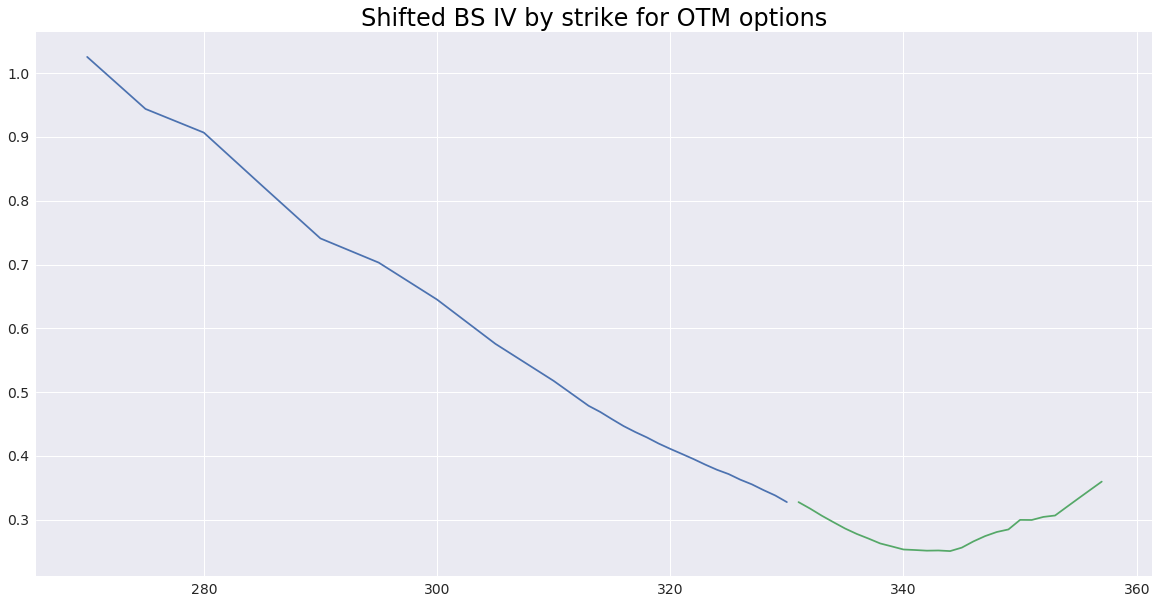

In [8]:
'''try:
    yahoo_shift = puts[puts.expiration == ex].sort_values('strike').yahoo_implied_vol.iloc[-1] - calls[calls.expiration == ex].sort_values('strike').yahoo_implied_vol.iloc[0]
    shift =  puts[puts.expiration == ex].sort_values('strike').implied_volatility.iloc[-1] - calls[ calls.expiration == ex ].sort_values('strike').implied_volatility.bfill().iloc[0]
except:
    yahoo_shift = 0
    shift = 0'''
plt.plot(puts[puts.expiration == ex].sort_values('strike').strike, puts[puts.expiration == ex].sort_values('strike').implied_volatility )
plt.plot(calls[calls.expiration == ex].sort_values('strike').strike, calls[calls.expiration == ex].sort_values('strike').implied_volatility.bfill()  )
plt.title('Shifted BS IV by strike for OTM options', fontsize = 24, color = 'black')

Text(0.5, 1.0, 'Yahoo IV by strike for OTM options')

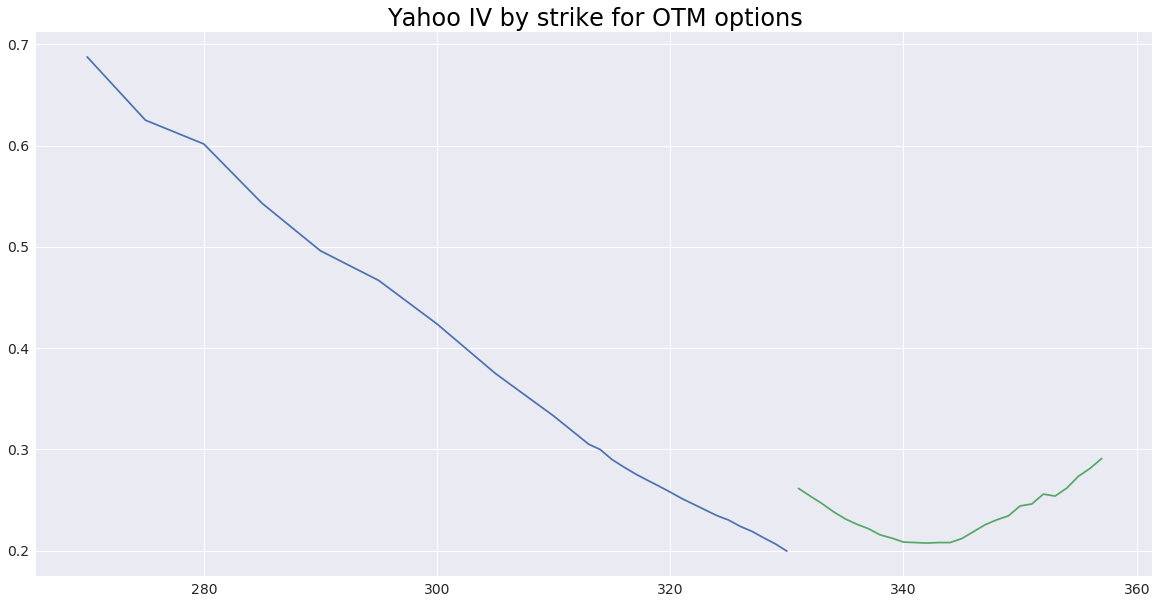

In [9]:
'''try:
    yahoo_shift = puts[puts.expiration == ex].sort_values('strike').yahoo_implied_vol.iloc[-1] - calls[calls.expiration == ex].sort_values('strike').yahoo_implied_vol.iloc[0]
except:
    yahoo_shift = 0'''
plt.plot(puts[puts.expiration == ex].sort_values('strike').strike, puts[puts.expiration == ex].sort_values('strike').yahoo_implied_vol )
plt.plot(calls[calls.expiration == ex].sort_values('strike').strike, calls[calls.expiration == ex].sort_values('strike').yahoo_implied_vol )
plt.title('Yahoo IV by strike for OTM options', fontsize = 24, color = 'black')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


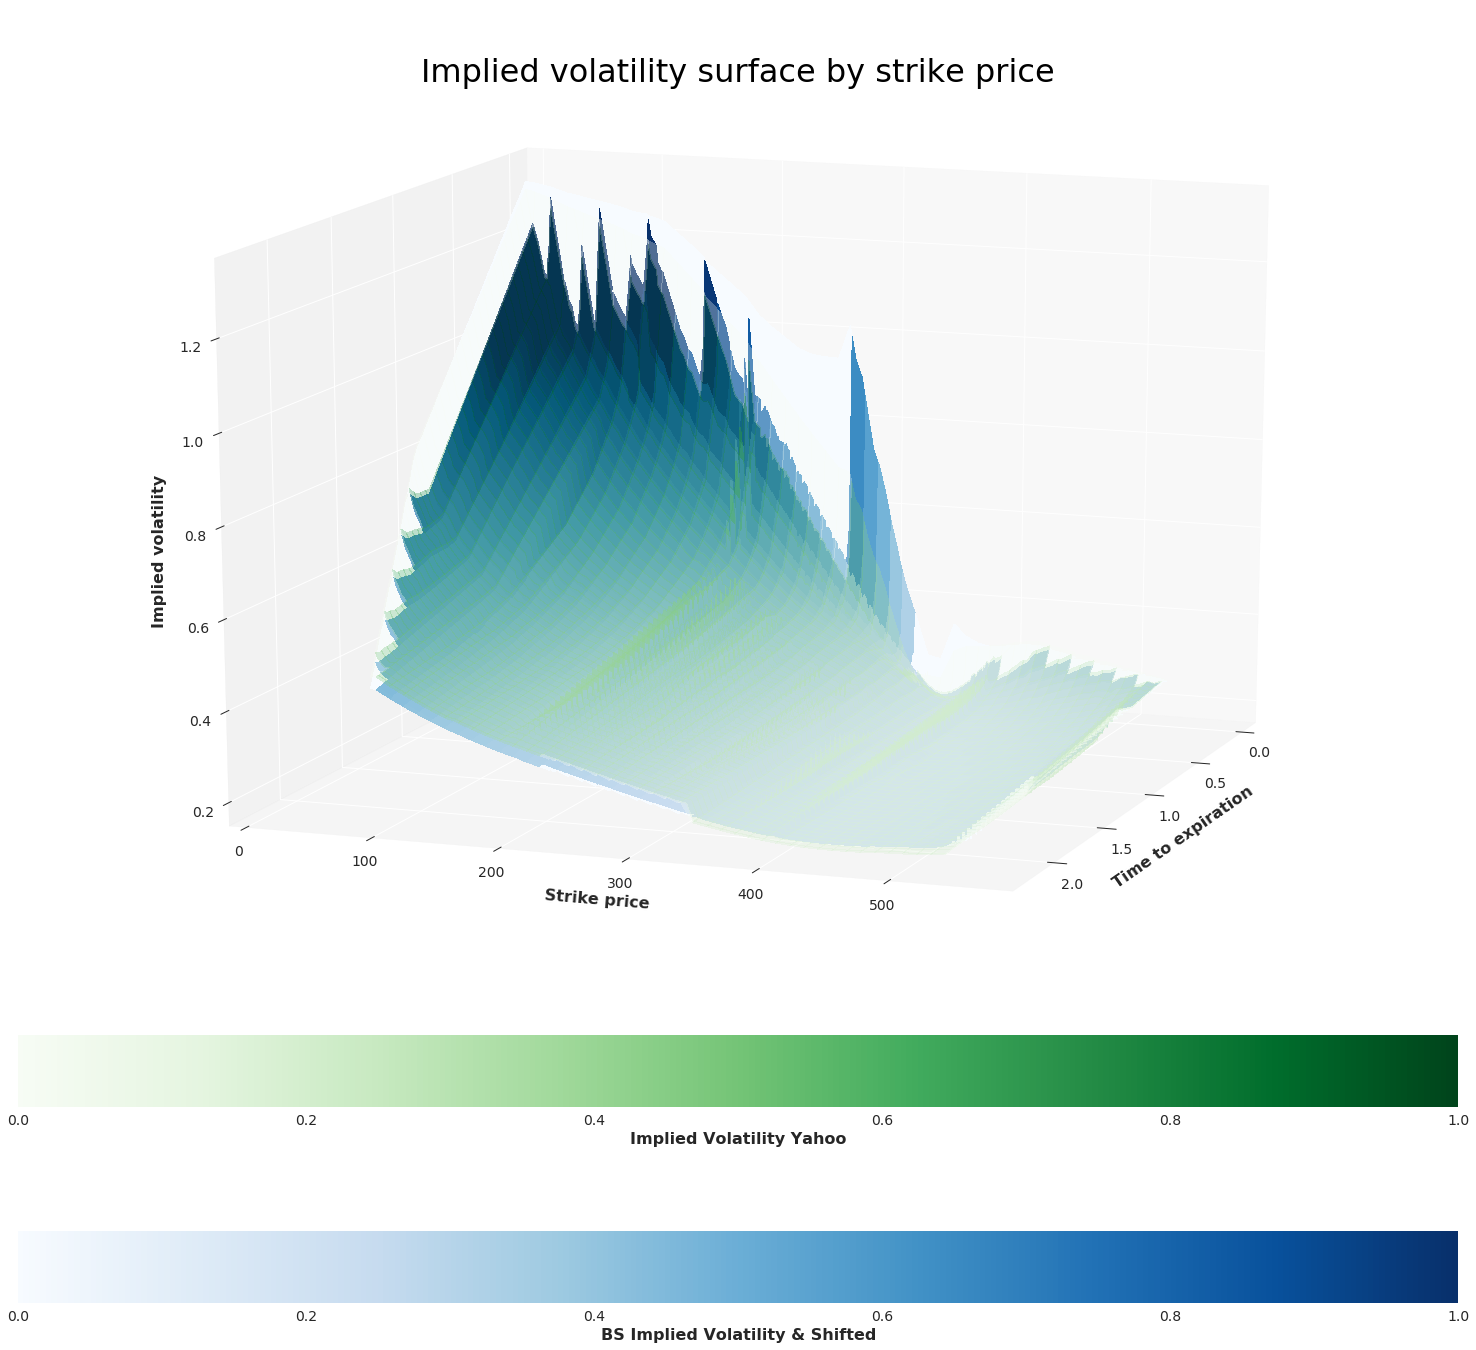

In [10]:
X = option_chain.time_to_expiration.values
Y = option_chain.strike.values
Z1 = option_chain.implied_volatility.values
Z2 = option_chain.yahoo_implied_vol.values

XX,YY,ZZ1 = fn.create_surface(X,Y,Z1, method = 'linear')
XX,YY,ZZ2 = fn.create_surface(X,Y,Z2, method = 'linear')

fig = plt.figure(figsize = (20, 20))

mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)
mappable.set_clim(0, 1)
mappable2 = plt.cm.ScalarMappable(cmap = plt.cm.Greens)
mappable2.set_array(Z2)
mappable2.set_clim(0, 1) # optional

ax = Axes3D(fig, azim = 20, elev = 15)
ax.plot_surface(XX, YY, ZZ1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.plot_surface(XX, YY, ZZ2, cmap=mappable2.cmap, norm=mappable2.norm, linewidth=0, alpha = 0.3, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_ylabel('Strike price', labelpad = 15.0)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar2 = plt.colorbar(mappable2, orientation="horizontal", pad = 0.011)
cbar.set_label('BS Implied Volatility & Shifted')
cbar2.set_label('Implied Volatility Yahoo')
plt.tight_layout()
plt.title('Implied volatility surface by strike price', fontsize = 32, color = 'black')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


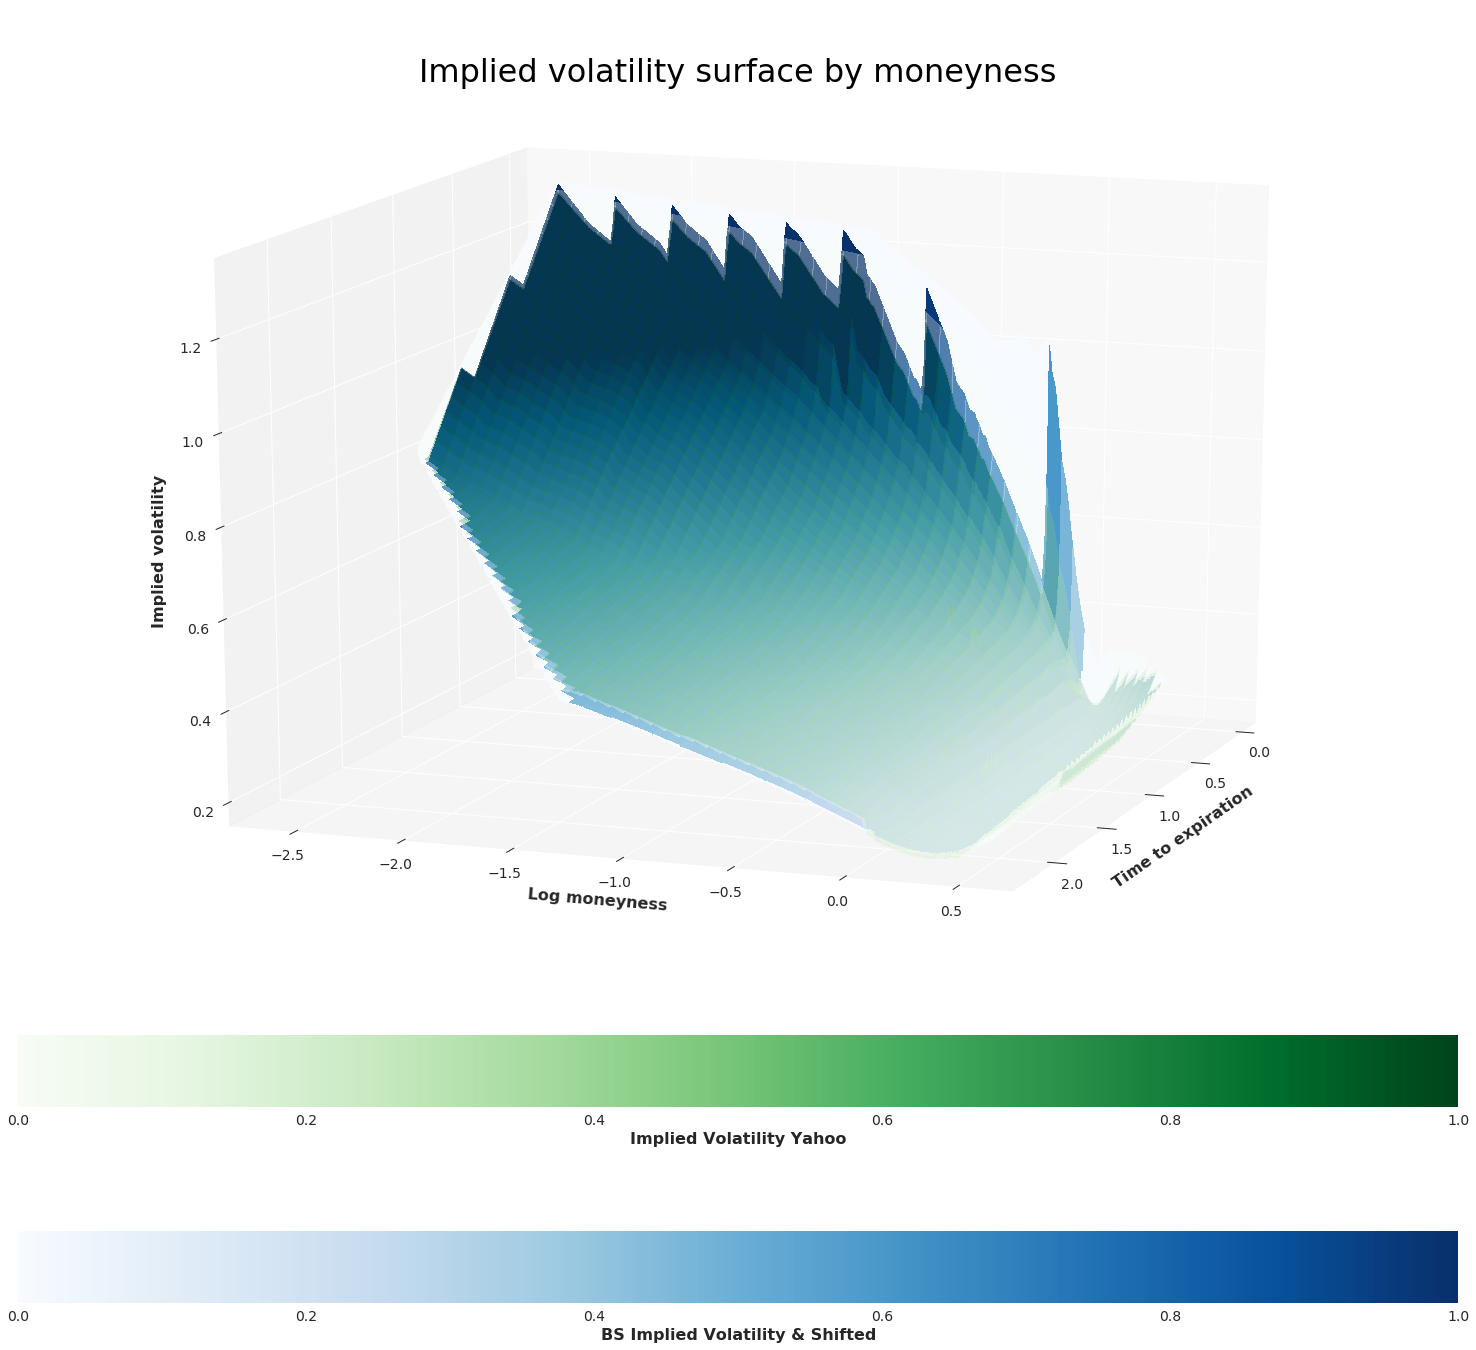

In [11]:
X = option_chain.time_to_expiration.values
Y = option_chain.log_moneyness.values
Z1 = option_chain.implied_volatility.values
Z2 = option_chain.yahoo_implied_vol.values

XX,YY,ZZ1 = fn.create_surface(X,Y,Z1, method = 'linear')
XX,YY,ZZ2 = fn.create_surface(X,Y,Z2, method = 'linear')

fig = plt.figure(figsize = (20, 20))

mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)
mappable.set_clim(0, 1)
mappable2 = plt.cm.ScalarMappable(cmap = plt.cm.Greens)
mappable2.set_array(Z2)
mappable2.set_clim(0, 1) # optional

ax = Axes3D(fig, azim = 20, elev = 15)
ax.plot_surface(XX, YY, ZZ1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.plot_surface(XX, YY, ZZ2, cmap=mappable2.cmap, norm=mappable2.norm, linewidth=0, alpha = 0.3, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_ylabel('Log moneyness', labelpad = 15.0)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar2 = plt.colorbar(mappable2, orientation="horizontal", pad = 0.011)
cbar.set_label('BS Implied Volatility & Shifted')
cbar2.set_label('Implied Volatility Yahoo')
plt.tight_layout()
plt.title('Implied volatility surface by moneyness', fontsize = 32, color = 'black')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


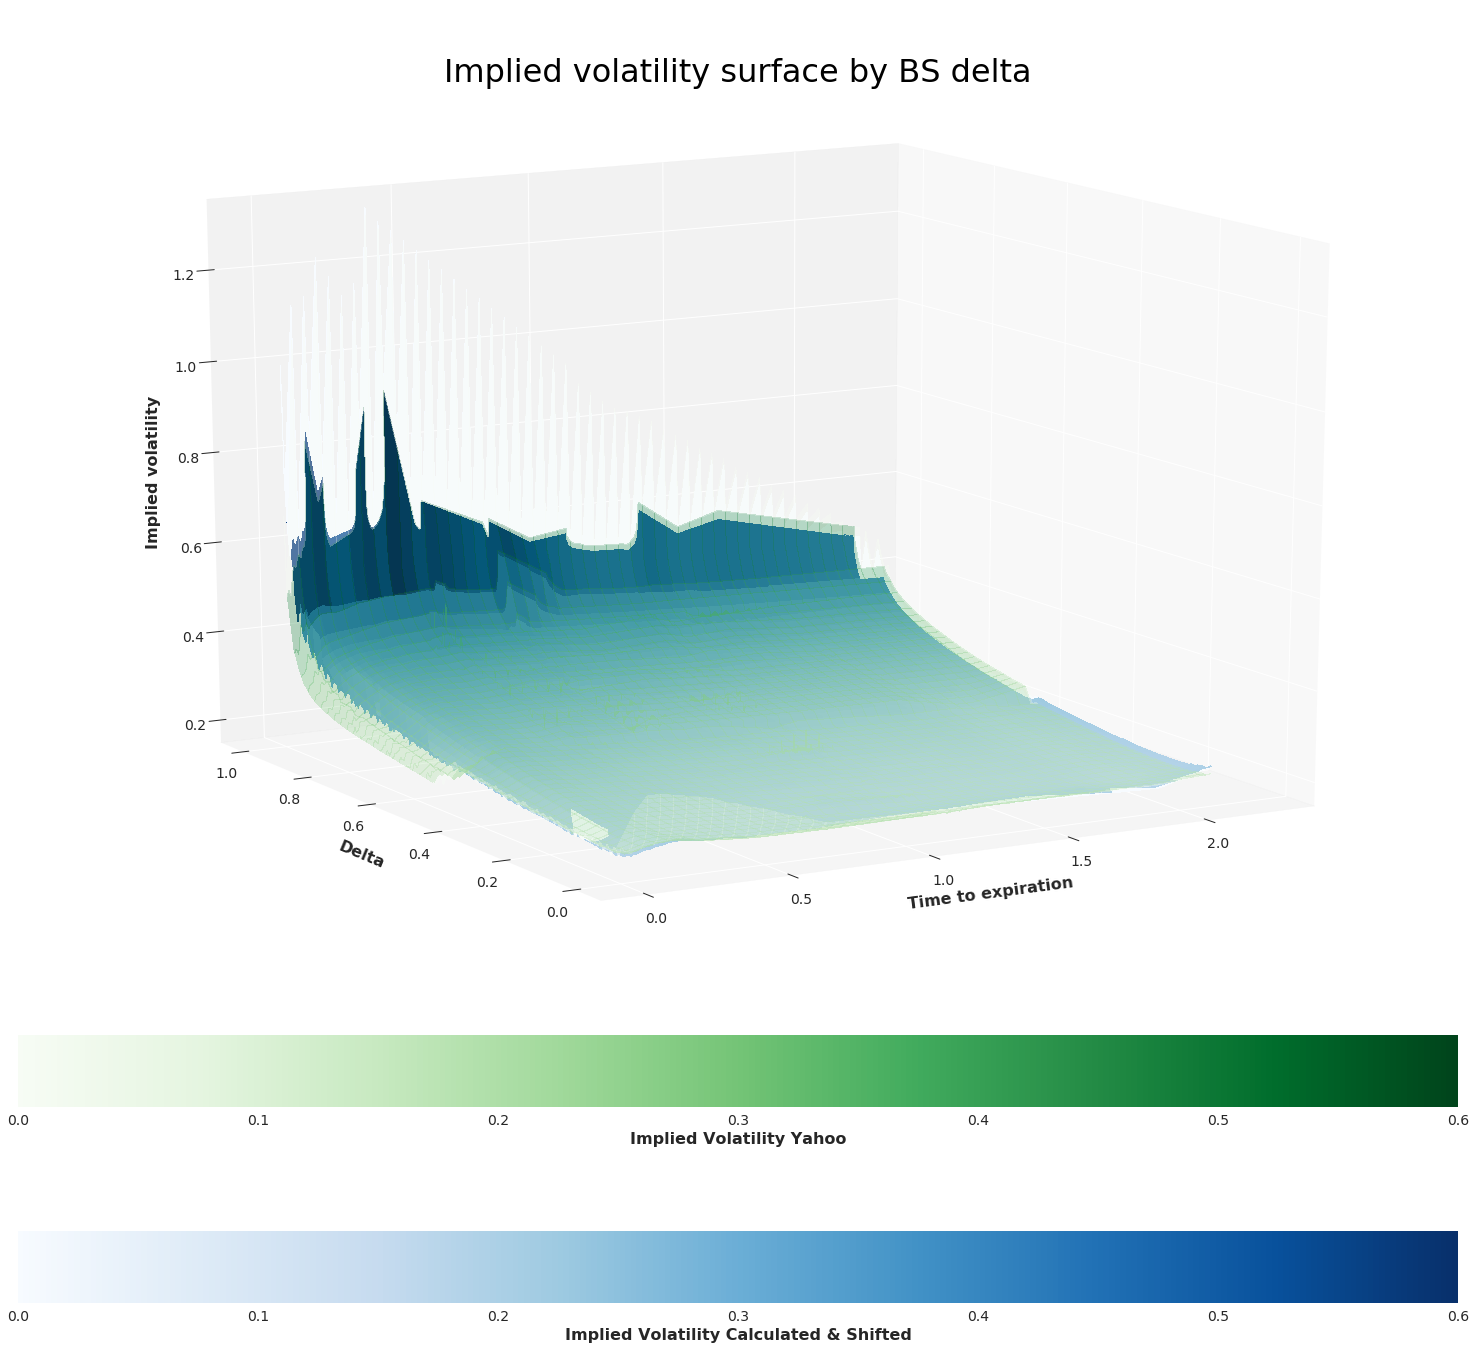

In [12]:
X = option_chain.time_to_expiration.values
Y = option_chain.delta.values
Z1 = option_chain.implied_volatility.values
Z2 = option_chain.yahoo_implied_vol.values

XX,YY,ZZ1 = fn.create_surface(X,Y,Z1, method = 'linear')
XX,YY,ZZ2 = fn.create_surface(X,Y,Z2, method = 'linear')

fig = plt.figure(figsize = (20, 20))

mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)
mappable.set_clim(0, 0.6)
mappable2 = plt.cm.ScalarMappable(cmap = plt.cm.Greens)
mappable2.set_array(Z2)
mappable2.set_clim(0, 0.6) # optional

ax = Axes3D(fig, azim = -120, elev = 15)
ax.plot_surface(XX, YY, ZZ1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.plot_surface(XX, YY, ZZ2, cmap=mappable2.cmap, norm=mappable2.norm, linewidth=0, alpha = 0.3, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_ylabel('Delta', labelpad = 15.0)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar2 = plt.colorbar(mappable2, orientation="horizontal", pad = 0.01)
cbar.set_label('Implied Volatility Calculated & Shifted')
cbar2.set_label('Implied Volatility Yahoo')
plt.tight_layout()
plt.title('Implied volatility surface by BS delta', fontsize = 32, color = 'black')
plt.show()

In [13]:
puts.expiration

67     2020-09-23
68     2020-09-23
69     2020-09-23
70     2020-09-23
71     2020-09-23
          ...    
2091   2022-12-16
2092   2022-12-16
2093   2022-12-16
2094   2022-12-16
2095   2022-12-16
Name: expiration, Length: 1957, dtype: datetime64[ns]

## Calculate Delta surface

In [ ]:
print('Calculating calls...')
df1, parameters1 = fn.delta_surface(option_chain, calls, underlying, 1, verbose = False)
print('Calculating puts...')
df2, parameters2 = fn.delta_surface(option_chain, puts, underlying, -1, verbose = False)
df = df1.append(df2)
#df.dropna(how = 'all', inplace = True)
df.sort_index(inplace = True)

Calculating calls...


In [ ]:
df

In [ ]:
plt.plot(df), #title = 'IV vs Delta (Parametrized)')
plt.title( 'Constructed delta curves', fontsize = 24, color = 'black')
plt.xlabel('Delta')
plt.ylabel('Parametrised variance * T')
plt.show()

The plot above shows the delta curves for the different expiration dates. The gaps and missing values will be interpolated/extrapolated below.

### Estimated parameters

The plots below show the estimated parameters a (log-moneyness), b (squared log-moneyness) and c (constant). The parameter for log-moneyness, a, decreases with time to expiration while the constant term increases with time to expiration. The parameter for squared log-moneyness stays fairly constant but increases for long time to expirations.

All three plots show a parameter outlier for the 2022-09-16 expiration date. There are no put options listed/available which should be the reason for the weird calibration. 

In [ ]:
# parameter dfs
parameters1 = pd.DataFrame( parameters1 )
parameters2 = pd.DataFrame( parameters2 )
parameters1 = parameters1.transpose()
parameters2 = parameters2.transpose()
# plot
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex = True, figsize = (20,14))
ax1.set_title('Estimated parameters by expiration date', fontsize = 24, color = 'black')
ax1.plot(parameters1.a, label = 'Calls', marker = 'X')
ax1.plot(parameters2.a, label = 'Puts', marker = 'o')
ax2.plot(parameters1.b, label = 'Calls', marker = 'X')
ax2.plot(parameters2.b, label = 'Puts', marker = 'o')
ax3.plot(parameters1.c, label = 'Calls', marker = 'X')
ax3.plot(parameters2.c, label = 'Puts', marker = 'o')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('a (log_moneyness)')
ax2.set_ylabel('b (squared log_moneyness)')
ax3.set_ylabel('c (constant)')
plt.show()

In [ ]:
option_chain[option_chain.expiration == pd.to_datetime('2020-10-19')]

### Parametrised implied volatility vs. observed

The figure below shows the good fit of the parametrised IV vs. the calculated IV.

In [ ]:
ex = expirations[14]
x = option_chain[option_chain.expiration == ex ].sort_values('log_moneyness').log_moneyness.values
y1 = option_chain[option_chain.expiration == ex ].sort_values('log_moneyness').implied_volatility.values
y2 = option_chain[option_chain.expiration == ex ].sort_values('log_moneyness').yahoo_implied_vol.values
T = option_chain[option_chain.expiration == ex ].time_to_expiration.iloc[0]
plt.axvline(0, color = 'black', alpha = 0.5)
plt.plot( x, (parameters1.a.loc[ex] * x + parameters1.b.loc[ex] * x**2 + parameters1.c.loc[ex]) / T, label = 'Parametrised IV' )
plt.plot( x, y1**2, marker = 'X', linewidth = 0, label = 'Calculated IV' )
plt.plot( x, y2**2, marker = 'o', linewidth = 0, label = 'Yahoo IV', alpha = 0.5 )
plt.legend()
plt.title(f'Parametrised Variance vs. BS and Yahoo - Expiration: {ex.date()}', fontsize = 24, color = 'black')
plt.savefig('parametrised_variance.png', dpi = 300)
plt.show()

## Interpolation and Extrapolation

In [ ]:
df.dropna(how = 'all', inplace = True) # dropping duplicate 0.5 if all nan
if df.iloc[8:10,:].index[0] == df.iloc[8:10,:].index[1]: # interpolating delta 0.5
    df.iloc[8,:] = (df.iloc[8] +  df.iloc[9]) / 2
    df = df.iloc[~(np.arange(df.shape[0]) == 9 )]
df_not_interpolated = df.copy()
df_not_interpolated


In [ ]:
# linear interpolation of 0.55 delta options (only one missing value)
df.loc[ :, df.isnull().sum(axis = 0) == 1 ] = df.loc[ :, df.isnull().sum(axis = 0) == 1 ].interpolate()
# linear interpolation of 0.55 delta options (only two missing value)
df.loc[ :, df.isnull().sum(axis = 0) == 2 ] = df.loc[ :, df.isnull().sum(axis = 0) == 2 ].interpolate()

In [ ]:
# redo interpolation by time
columns = df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns
#columns


In [ ]:
# Interpolation of non-atm missing values by time
columns = df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns
#df.columns.get_loc( df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns[0] )
for col in columns:
    col_index = df.columns.get_loc( df[col].name )
    atm_interpolation = ((df.iloc[8, col_index+1] + df.iloc[8, col_index-1])/2)
    scale_factor = df.iloc[8, col_index] / atm_interpolation
    prev = df[ df.iloc[:, col_index].isna() ].iloc[:, col_index+1]
    after = df[ df.iloc[:, col_index].isna() ].iloc[:, col_index-1]
    df.loc[ df.iloc[:, col_index].isna(), col ] = ( prev + after )/2 * scale_factor


In [ ]:
# Interpolation of atm missing values with available puts
columns = df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns
#df.columns.get_loc( df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns[0] )
for col in columns:
    col_index = df.columns.get_loc( df[col].name )
    atm_interpolation = ((df.iloc[9, col_index+1] + df.iloc[9, col_index-1])/2)
    scale_factor = df.iloc[9, col_index] / atm_interpolation
    prev = df[ df.iloc[:, col_index].isna() ].iloc[:, col_index+1]
    after = df[ df.iloc[:, col_index].isna() ].iloc[:, col_index-1]
    df.loc[ df.iloc[:, col_index].isna(), col ] = ( prev + after )/2 * scale_factor

# Interpolation of atm missing values with available calls
columns = df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns
#df.columns.get_loc( df.loc[ :, df.isnull().sum(axis = 0) != 0 ].columns[0] )
for col in columns:
    col_index = df.columns.get_loc( df[col].name )
    atm_interpolation = ((df.iloc[7, col_index+1] + df.iloc[7, col_index-1])/2)
    scale_factor = df.iloc[7, col_index] / atm_interpolation
    prev = df[ df.iloc[:, col_index].isna() ].iloc[:, col_index+1]
    after = df[ df.iloc[:, col_index].isna() ].iloc[:, col_index-1]
    df.loc[ df.iloc[:, col_index].isna(), col ] = ( prev + after )/2 * scale_factor



The plot below shows the implied volatility surface constructed with delta and the interpolated values.

In [ ]:
X = ((pd.to_datetime(df.columns.values) - dt.datetime.today()) / dt.timedelta(365,0,0,0)).values.flatten()
Y = df.index.values.flatten()
Z1 = np.sqrt( df_not_interpolated.values / X ) 
Z2 = np.sqrt( df.values / X ) 

XX, YY = np.meshgrid(X,Y)

fig = plt.figure(figsize = (20,16))
mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)
mappable.set_clim(min(Z1.flatten()), 0.4)#max(Z1.flatten())) # optional
mappable2 = plt.cm.ScalarMappable(cmap = plt.cm.Greens)
mappable2.set_array(Z2)
mappable2.set_clim(min(Z2.flatten()), 0.4)#max(Z2.flatten())) # optional

ax = Axes3D(fig, azim = -60, elev = 15)
ax.plot_surface(XX, YY, Z1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.plot_surface(XX, YY, Z2, cmap=mappable2.cmap, norm=mappable2.norm, linewidth=0, alpha = 0.3, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_ylabel('Delta', labelpad = 15.0)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar2 = plt.colorbar(mappable2, orientation="horizontal", pad = 0.011)
cbar.set_label('Implied Volatility non-interpolated')
cbar2.set_label('Implied Volatility interpolated')
plt.tight_layout()
plt.title('Implied volatility surface by delta', fontsize = 32, color = 'black')
plt.show()


In [ ]:
df

## Time standardisation

In [ ]:
time_to_expiration = ((pd.to_datetime(df.columns.values) - dt.datetime.today()) / dt.timedelta(365,0,0,0)).values.flatten()
df.columns = time_to_expiration * 365 

In [ ]:
ts = [30, 60, 90, 120, 150, 180, 270, 360, 720]
df_standardised = pd.DataFrame( np.zeros( (len(df), len(ts)) ), columns = ts, index = df.index )
for t in ts:
    df_standardised[t] = fn.standardise_expiration(df, t)
# rescale to volatility
df_standardised_iv = np.sqrt( df_standardised / np.array( [df_standardised.columns.values] * len(df) ) * 365 )

In [ ]:
X = df_standardised_iv.columns.values.flatten()
Y = df.index.values.flatten()
Z1 = df_standardised_iv.values

XX, YY = np.meshgrid(X,Y)

fig = plt.figure(figsize = (20,16))
mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)
mappable.set_clim(min(Z1.flatten())-0.05, max(Z1.flatten())) # optional


ax = Axes3D(fig, azim = -120, elev = 15)
ax.plot_surface(XX, YY, Z1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_xticks(df_standardised_iv.columns.values.flatten())
ax.set_ylabel('Delta', labelpad = 15.0)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar.set_label('Implied Volatility')
plt.tight_layout()
plt.title('Implied volatility surface by delta', fontsize = 32, color = 'black')
plt.savefig('implied_volatility_surface_by_delta.png', dpi = 300)
plt.show()



## Delta to strike price

In [ ]:
df_strikes = df_standardised_iv.copy()
time_to_expiration = ( df_standardised_iv.columns.values / 365 ).flatten()
q = T = 0 # assuming 0 dividends for forward price
F = underlying.close.iloc[-1] * np.exp(-q*T)
for i, d in enumerate(df_standardised_iv.index):
    for j, t in enumerate(time_to_expiration):
        df_strikes.iloc[i,j] = F*np.exp(-(norm.ppf(d)+0.5)*df_standardised_iv.iloc[i,j]*np.sqrt(t))

df_strikes = df_strikes.transpose()
temp = df_strikes.iloc[:,0]
for col in range(1,len(df_strikes.columns)):
    temp = temp.append(df_strikes.iloc[:,col])
df_strikes = pd.DataFrame( temp, columns = ['strike'] )
df_strikes.index.name = 'time_to_expiration'
df_strikes.reset_index(inplace = True)
temp = df_standardised_iv.transpose().iloc[:,0]
for col in range(1,len(df_standardised_iv.transpose().columns)):
    temp = temp.append(df_standardised_iv.transpose().iloc[:,col])
df_strikes['implied_volatility'] = temp.values
df_strikes.time_to_expiration = df_strikes.time_to_expiration.values
#df_moneyness = np.log( df_strikes / F )

In [ ]:
df_strikes.dropna(inplace = True)

In [ ]:
X = df_strikes.time_to_expiration.values
Y = df_strikes.strike.values
Z1 = df_strikes.implied_volatility.values

XX,YY,ZZ1 = fn.create_surface(X,Y,Z1, method = 'linear')

fig = plt.figure(figsize = (20, 20))

mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)
#mappable.set_clim(0, 1)

ax = Axes3D(fig, azim = 60, elev = 15)
ax.plot_surface(XX, YY, ZZ1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_xticks(df_standardised_iv.columns.values.flatten())
ax.set_ylabel('Strike price', labelpad = 15.0)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar.set_label('Implied volatility calculated with delta')
plt.tight_layout()
plt.title('Volatility surface by virtual strike price', fontsize = 32, color = 'black')
plt.show()

In [ ]:
X = df_strikes.time_to_expiration.values
Y = np.log(df_strikes.strike / F).values
Z1 = df_strikes.implied_volatility.values

XX,YY,ZZ1 = fn.create_surface(X,Y,Z1, method = 'linear')

fig = plt.figure(figsize = (20, 20))

mappable = plt.cm.ScalarMappable(cmap = plt.cm.Blues)
mappable.set_array(Z1)

ax = Axes3D(fig, azim = 60, elev = 15)
ax.plot_surface(XX, YY, ZZ1, cmap=mappable.cmap, norm=mappable.norm, linewidth=1, antialiased=False)
ax.set_facecolor('white')
ax.set_xlabel('Time to expiration', labelpad = 15.0)
ax.set_ylabel('Log moneyness', labelpad = 15.0)
ax.set_xticks(df_standardised_iv.columns.values.flatten())
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Implied volatility', rotation = 90, labelpad = 15.0)
cbar = plt.colorbar(mappable, orientation="horizontal", pad = 0.01)
cbar.set_label('Implied volatility calculated with delta')
plt.tight_layout()
plt.title('Volatility surface by moneyness', fontsize = 32, color = 'black')
plt.show()
#plt.savefig('implied_volatility_surface_by_delta.png', dpi = 300)